In [8]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")



TensorFlow version: 2.19.0
Keras version: 3.9.2


In [ ]:
def load_data():
    """Load preprocessed train, validation, and test sets"""
    print("Loading preprocessed data...")
    
    X_train = pd.read_csv('X_train.csv')
    X_val = pd.read_csv('X_val.csv')
    X_test = pd.read_csv('X_test.csv')
    
    y_train = pd.read_csv('y_train.csv').values.ravel()
    y_val = pd.read_csv('y_val.csv').values.ravel()
    y_test = pd.read_csv('y_test.csv').values.ravel()
    
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = load_data()

Loading preprocessed data...
Training set: (5040798, 18)
Validation set: (1680266, 18)
Test set: (1680267, 18)


In [10]:
def prepare_data(X_train, X_val, X_test, y_train, y_val, y_test):
    """Normalize features and encode labels"""
    print("\nPreparing data for CNN-LSTM...")
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)
    
    num_classes = len(label_encoder.classes_)
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {label_encoder.classes_}")
    
    # Reshape for CNN-LSTM: (samples, timesteps, features)
    n_features = X_train_scaled.shape[1]
    timesteps = 1
    
    X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], timesteps, n_features)
    X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], timesteps, n_features)
    X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], timesteps, n_features)
    
    print(f"\nReshaped data:")
    print(f"X_train: {X_train_reshaped.shape}")
    print(f"X_val: {X_val_reshaped.shape}")
    print(f"X_test: {X_test_reshaped.shape}")
    
    return (X_train_reshaped, X_val_reshaped, X_test_reshaped,
            y_train_encoded, y_val_encoded, y_test_encoded,
            scaler, label_encoder, num_classes)

X_train_prep, X_val_prep, X_test_prep, y_train_enc, y_val_enc, y_test_enc, scaler, label_encoder, num_classes = prepare_data(
    X_train, X_val, X_test, y_train, y_val, y_test
)




Preparing data for CNN-LSTM...
Number of classes: 15
Classes: ['Backdoor' 'DDoS_HTTP' 'DDoS_ICMP' 'DDoS_TCP' 'DDoS_UDP' 'Fingerprinting'
 'MITM' 'Normal' 'Password' 'Port_Scanning' 'Ransomware' 'SQL_injection'
 'Uploading' 'Vulnerability_scanner' 'XSS']

Reshaped data:
X_train: (5040798, 1, 18)
X_val: (1680266, 1, 18)
X_test: (1680267, 1, 18)


In [ ]:
def build_binary_cnn_lstm(input_shape):
    """
    Build CNN-LSTM model for binary classification
    Architecture based on HIDS-IoMT paper
    """
    model = models.Sequential([
        # CNN Layers for feature extraction
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', 
                     input_shape=input_shape, padding='same', name='conv1d_1'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=1),
        layers.Dropout(0.2),
        
        layers.Conv1D(filters=128, kernel_size=3, activation='relu', 
                     padding='same', name='conv1d_2'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=1),
        layers.Dropout(0.2),
        
        layers.Conv1D(filters=256, kernel_size=3, activation='relu', 
                     padding='same', name='conv1d_3'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=1),
        layers.Dropout(0.2),
        
        # LSTM Layers for temporal dependencies
        layers.LSTM(128, return_sequences=True, name='lstm_1'),
        layers.Dropout(0.2),
        
        layers.LSTM(64, return_sequences=False, name='lstm_2'),
        layers.Dropout(0.2),
        
        # Dense Layers for classification
        layers.Dense(128, activation='relu', name='dense_1'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(64, activation='relu', name='dense_2'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Output layer for binary classification
        layers.Dense(1, activation='sigmoid', name='output')
    ])
    
    return model



In [12]:
def build_multiclass_cnn_lstm(input_shape, num_classes):
    """
    Build CNN-LSTM model for multiclass classification
    Architecture based on HIDS-IoMT paper
    """
    model = models.Sequential([
        # CNN Layers for feature extraction
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', 
                     input_shape=input_shape, padding='same', name='conv1d_1'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=1),
        layers.Dropout(0.2),
        
        layers.Conv1D(filters=128, kernel_size=3, activation='relu', 
                     padding='same', name='conv1d_2'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=1),
        layers.Dropout(0.2),
        
        layers.Conv1D(filters=256, kernel_size=3, activation='relu', 
                     padding='same', name='conv1d_3'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=1),
        layers.Dropout(0.2),
        
        # LSTM Layers for temporal dependencies
        layers.LSTM(128, return_sequences=True, name='lstm_1'),
        layers.Dropout(0.2),
        
        layers.LSTM(64, return_sequences=False, name='lstm_2'),
        layers.Dropout(0.2),
        
        # Dense Layers for classification
        layers.Dense(128, activation='relu', name='dense_1'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(64, activation='relu', name='dense_2'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Output layer for multiclass classification
        layers.Dense(num_classes, activation='softmax', name='output')
    ])
    
    return model


In [13]:
def compile_and_train_binary(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=128):
    """Compile and train binary classification model"""
    
    print("\nCompiling binary classification model...")
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
    )
    
    print("\nModel Summary:")
    model.summary()
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    model_checkpoint = ModelCheckpoint(
        'best_binary_cnn_lstm_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
    
    print("\nTraining binary classification model...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        verbose=1
    )
    
    return model, history




In [19]:
def compile_and_train_multiclass(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=128):
    """Compile and train multiclass classification model"""
    
    print("\nCompiling multiclass classification model...")
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("\nModel Summary:")
    model.summary()
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    model_checkpoint = ModelCheckpoint(
        'best_multiclass_cnn_lstm_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
    
    print("\nTraining multiclass classification model...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        verbose=1
    )
    
    return model, history

In [20]:
def evaluate_model(model, X_test, y_test, label_encoder, is_binary=False):
    """Evaluate model performance"""
    
    print("\n" + "="*70)
    print("MODEL EVALUATION")
    print("="*70)
    
    # Predictions
    y_pred_proba = model.predict(X_test, verbose=0)
    
    if is_binary:
        y_pred = (y_pred_proba > 0.5).astype(int).ravel()
    else:
        y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    if is_binary:
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
    else:
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    print(f"\nAccuracy:  {accuracy*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall:    {recall*100:.2f}%")
    print(f"F1-Score:  {f1*100:.2f}%")
    
    # Classification report
    print("\n" + "="*70)
    print("CLASSIFICATION REPORT")
    print("="*70)
    if is_binary:
        target_names = ['Normal', 'Attack']
    else:
        target_names = label_encoder.classes_
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return accuracy, precision, recall, f1, cm, y_pred


In [ ]:
def plot_training_history(history, save_path='training_history.png'):
    """Plot training and validation metrics"""
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Plot accuracy
    axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nTraining history plot saved: {save_path}")
    plt.show()


def plot_confusion_matrix(cm, labels, save_path='confusion_matrix.png'):
    """Plot confusion matrix"""
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Confusion matrix plot saved: {save_path}")
    plt.show()




MULTICLASS CLASSIFICATION MODE

Compiling multiclass classification model...

Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 1, 64)          │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 393,423 (1.50 MB)

 Trainable params: 392,143 (1.50 MB)

 Non-trainable params: 1,280 (5.00 KB)


Training multiclass classification model...
Epoch 1/50
Epoch 1/50
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7731 - loss: 0.4962
Epoch 1: val_accuracy improved from -inf to 0.82514, saving model to best_multiclass_cnn_lstm_model.h5

Epoch 1: val_accuracy improved from -inf to 0.82514, saving model to best_multiclass_cnn_lstm_model.h5


39382/39382 ━━━━━━━━━━━━━━━━━━━━ 460s 12ms/step - accuracy: 0.7731 - loss: 0.4962 - val_accuracy: 0.8251 - val_loss: 0.3663 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
39380/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8220 - loss: 0.3804
Epoch 2: val_accuracy improved from 0.82514 to 0.82857, saving model to best_multiclass_cnn_lstm_model.h5

Epoch 2: val_accuracy improved from 0.82514 to 0.82857, saving model to best_multiclass_cnn_lstm_model.h5


39382/39382 ━━━━━━━━━━━━━━━━━━━━ 466s 12ms/step - accuracy: 0.8220 - loss: 0.3804 - val_accuracy: 0.8286 - val_loss: 0.3605 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
39378/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8247 - loss: 0.3717
Epoch 3: val_accuracy did not improve from 0.82857
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 460s 12ms/step - accuracy: 0.8247 - loss: 0.3717 - val_accuracy: 0.8281 - val_loss: 0.3537 - learning_rate: 0.0010
Epoch 4/50

Epoch 3: val_accuracy did not improve from 0.82857
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 460s 12ms/step - accuracy: 0.8247 - loss: 0.3717 - val_accuracy: 0.8281 - val_loss: 0.3537 - learning_rate: 0.0010
Epoch 4/50
39381/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8259 - loss: 0.3682
Epoch 4: val_accuracy improved from 0.82857 to 0.83147, saving model to best_multiclass_cnn_lstm_model.h5

Epoch 4: val_accuracy improved from 0.82857 to 0.83147, saving model to best_multiclass_cnn_lstm_model.h5


39382/39382 ━━━━━━━━━━━━━━━━━━━━ 396s 10ms/step - accuracy: 0.8259 - loss: 0.3682 - val_accuracy: 0.8315 - val_loss: 0.3539 - learning_rate: 0.0010
Epoch 5/50
Epoch 5/50
39377/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8268 - loss: 0.3656
Epoch 5: val_accuracy did not improve from 0.83147
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 414s 10ms/step - accuracy: 0.8268 - loss: 0.3656 - val_accuracy: 0.8301 - val_loss: 0.3554 - learning_rate: 0.0010
Epoch 6/50

Epoch 5: val_accuracy did not improve from 0.83147
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 414s 10ms/step - accuracy: 0.8268 - loss: 0.3656 - val_accuracy: 0.8301 - val_loss: 0.3554 - learning_rate: 0.0010
Epoch 6/50
39379/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8272 - loss: 0.3640
Epoch 6: val_accuracy did not improve from 0.83147
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 413s 10ms/step - accuracy: 0.8272 - loss: 0.3640 - val_accuracy: 0.8302 - val_loss: 0.3531 - learning_rate: 0.0010
Epoch 7/50

Epoch 6: val_accuracy did not improve 

39382/39382 ━━━━━━━━━━━━━━━━━━━━ 414s 10ms/step - accuracy: 0.8280 - loss: 0.3621 - val_accuracy: 0.8324 - val_loss: 0.3503 - learning_rate: 0.0010
Epoch 8/50
Epoch 8/50
39381/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8280 - loss: 0.3615
Epoch 8: val_accuracy improved from 0.83236 to 0.83268, saving model to best_multiclass_cnn_lstm_model.h5

Epoch 8: val_accuracy improved from 0.83236 to 0.83268, saving model to best_multiclass_cnn_lstm_model.h5


39382/39382 ━━━━━━━━━━━━━━━━━━━━ 414s 11ms/step - accuracy: 0.8280 - loss: 0.3615 - val_accuracy: 0.8327 - val_loss: 0.3483 - learning_rate: 0.0010
Epoch 9/50
Epoch 9/50
39379/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8280 - loss: 0.3608
Epoch 9: val_accuracy did not improve from 0.83268
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 411s 10ms/step - accuracy: 0.8280 - loss: 0.3608 - val_accuracy: 0.8322 - val_loss: 0.3497 - learning_rate: 0.0010
Epoch 10/50

Epoch 9: val_accuracy did not improve from 0.83268
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 411s 10ms/step - accuracy: 0.8280 - loss: 0.3608 - val_accuracy: 0.8322 - val_loss: 0.3497 - learning_rate: 0.0010
Epoch 10/50
39380/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8280 - loss: 0.3623
Epoch 10: val_accuracy did not improve from 0.83268
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 413s 10ms/step - accuracy: 0.8280 - loss: 0.3623 - val_accuracy: 0.8308 - val_loss: 0.3512 - learning_rate: 0.0010
Epoch 11/50

Epoch 10: val_accuracy did not impro

39382/39382 ━━━━━━━━━━━━━━━━━━━━ 415s 11ms/step - accuracy: 0.8284 - loss: 0.3604 - val_accuracy: 0.8336 - val_loss: 0.3476 - learning_rate: 0.0010
Epoch 13/50
Epoch 13/50
39379/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8282 - loss: 0.3605
Epoch 13: val_accuracy did not improve from 0.83357
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 414s 11ms/step - accuracy: 0.8282 - loss: 0.3605 - val_accuracy: 0.8313 - val_loss: 0.3492 - learning_rate: 0.0010
Epoch 14/50

Epoch 13: val_accuracy did not improve from 0.83357
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 414s 11ms/step - accuracy: 0.8282 - loss: 0.3605 - val_accuracy: 0.8313 - val_loss: 0.3492 - learning_rate: 0.0010
Epoch 14/50
39378/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8291 - loss: 0.3595
Epoch 14: val_accuracy did not improve from 0.83357
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 417s 11ms/step - accuracy: 0.8291 - loss: 0.3595 - val_accuracy: 0.8306 - val_loss: 0.3483 - learning_rate: 0.0010
Epoch 15/50

Epoch 14: val_accuracy did not

39382/39382 ━━━━━━━━━━━━━━━━━━━━ 443s 11ms/step - accuracy: 0.8296 - loss: 0.3570 - val_accuracy: 0.8336 - val_loss: 0.3471 - learning_rate: 0.0010
Epoch 27/50
Epoch 27/50
39378/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8299 - loss: 0.3565
Epoch 27: val_accuracy improved from 0.83360 to 0.83387, saving model to best_multiclass_cnn_lstm_model.h5

Epoch 27: val_accuracy improved from 0.83360 to 0.83387, saving model to best_multiclass_cnn_lstm_model.h5


39382/39382 ━━━━━━━━━━━━━━━━━━━━ 435s 11ms/step - accuracy: 0.8299 - loss: 0.3565 - val_accuracy: 0.8339 - val_loss: 0.3459 - learning_rate: 0.0010
Epoch 28/50
Epoch 28/50
39378/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8299 - loss: 0.3563
Epoch 28: val_accuracy did not improve from 0.83387
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 443s 11ms/step - accuracy: 0.8299 - loss: 0.3563 - val_accuracy: 0.8329 - val_loss: 0.3454 - learning_rate: 0.0010
Epoch 29/50

Epoch 28: val_accuracy did not improve from 0.83387
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 443s 11ms/step - accuracy: 0.8299 - loss: 0.3563 - val_accuracy: 0.8329 - val_loss: 0.3454 - learning_rate: 0.0010
Epoch 29/50
39379/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8295 - loss: 0.3565
Epoch 29: val_accuracy improved from 0.83387 to 0.83409, saving model to best_multiclass_cnn_lstm_model.h5

Epoch 29: val_accuracy improved from 0.83387 to 0.83409, saving model to best_multiclass_cnn_lstm_model.h5


39382/39382 ━━━━━━━━━━━━━━━━━━━━ 444s 11ms/step - accuracy: 0.8295 - loss: 0.3565 - val_accuracy: 0.8341 - val_loss: 0.3451 - learning_rate: 0.0010
Epoch 30/50
Epoch 30/50
39377/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8299 - loss: 0.3561
Epoch 30: val_accuracy did not improve from 0.83409
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 446s 11ms/step - accuracy: 0.8299 - loss: 0.3561 - val_accuracy: 0.8339 - val_loss: 0.3451 - learning_rate: 0.0010
Epoch 31/50

Epoch 30: val_accuracy did not improve from 0.83409
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 446s 11ms/step - accuracy: 0.8299 - loss: 0.3561 - val_accuracy: 0.8339 - val_loss: 0.3451 - learning_rate: 0.0010
Epoch 31/50
39381/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8295 - loss: 0.3565
Epoch 31: val_accuracy did not improve from 0.83409
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 446s 11ms/step - accuracy: 0.8295 - loss: 0.3565 - val_accuracy: 0.8338 - val_loss: 0.3463 - learning_rate: 0.0010
Epoch 32/50

Epoch 31: val_accuracy did not

39382/39382 ━━━━━━━━━━━━━━━━━━━━ 447s 11ms/step - accuracy: 0.8298 - loss: 0.3568 - val_accuracy: 0.8342 - val_loss: 0.3456 - learning_rate: 0.0010
Epoch 33/50
Epoch 33/50
39381/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8293 - loss: 0.3569
Epoch 33: val_accuracy did not improve from 0.83420
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 450s 11ms/step - accuracy: 0.8293 - loss: 0.3569 - val_accuracy: 0.8314 - val_loss: 0.3497 - learning_rate: 0.0010
Epoch 34/50

Epoch 33: val_accuracy did not improve from 0.83420
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 450s 11ms/step - accuracy: 0.8293 - loss: 0.3569 - val_accuracy: 0.8314 - val_loss: 0.3497 - learning_rate: 0.0010
Epoch 34/50
39379/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8302 - loss: 0.3555
Epoch 34: val_accuracy did not improve from 0.83420

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 455s 12ms/step - accuracy: 0.8302 - loss: 0.3555 - val_accuracy: 0.8336 - val_lo

39382/39382 ━━━━━━━━━━━━━━━━━━━━ 463s 12ms/step - accuracy: 0.8310 - loss: 0.3524 - val_accuracy: 0.8354 - val_loss: 0.3418 - learning_rate: 5.0000e-04
Epoch 36/50
Epoch 36/50
39381/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8316 - loss: 0.3505
Epoch 36: val_accuracy did not improve from 0.83536
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 461s 12ms/step - accuracy: 0.8316 - loss: 0.3505 - val_accuracy: 0.8343 - val_loss: 0.3433 - learning_rate: 5.0000e-04
Epoch 37/50

Epoch 36: val_accuracy did not improve from 0.83536
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 461s 12ms/step - accuracy: 0.8316 - loss: 0.3505 - val_accuracy: 0.8343 - val_loss: 0.3433 - learning_rate: 5.0000e-04
Epoch 37/50
39381/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8315 - loss: 0.3506
Epoch 37: val_accuracy did not improve from 0.83536
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 467s 12ms/step - accuracy: 0.8315 - loss: 0.3506 - val_accuracy: 0.8353 - val_loss: 0.3410 - learning_rate: 5.0000e-04
Epoch 38/50

Epoch 37: val_

39382/39382 ━━━━━━━━━━━━━━━━━━━━ 485s 12ms/step - accuracy: 0.8322 - loss: 0.3496 - val_accuracy: 0.8356 - val_loss: 0.3413 - learning_rate: 5.0000e-04
Epoch 42/50
Epoch 42/50
39381/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8325 - loss: 0.3490
Epoch 42: val_accuracy did not improve from 0.83562
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 484s 12ms/step - accuracy: 0.8325 - loss: 0.3490 - val_accuracy: 0.8338 - val_loss: 0.3401 - learning_rate: 5.0000e-04
Epoch 43/50

Epoch 42: val_accuracy did not improve from 0.83562
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 484s 12ms/step - accuracy: 0.8325 - loss: 0.3490 - val_accuracy: 0.8338 - val_loss: 0.3401 - learning_rate: 5.0000e-04
Epoch 43/50
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8324 - loss: 0.3489
Epoch 43: val_accuracy did not improve from 0.83562
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 486s 12ms/step - accuracy: 0.8324 - loss: 0.3489 - val_accuracy: 0.8333 - val_loss: 0.3417 - learning_rate: 5.0000e-04
Epoch 44/50

Epoch 43: val_

39382/39382 ━━━━━━━━━━━━━━━━━━━━ 499s 13ms/step - accuracy: 0.8318 - loss: 0.3501 - val_accuracy: 0.8358 - val_loss: 0.3410 - learning_rate: 5.0000e-04
Epoch 47/50
Epoch 47/50
39379/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8325 - loss: 0.3495
Epoch 47: val_accuracy did not improve from 0.83576

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 503s 13ms/step - accuracy: 0.8325 - loss: 0.3495 - val_accuracy: 0.8357 - val_loss: 0.3419 - learning_rate: 5.0000e-04
Epoch 48/50

Epoch 47: val_accuracy did not improve from 0.83576

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 503s 13ms/step - accuracy: 0.8325 - loss: 0.3495 - val_accuracy: 0.8357 - val_loss: 0.3419 - learning_rate: 5.0000e-04
Epoch 48/50
39380/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8330 - loss: 0.3479
Epoch 48: val_accuracy improved from 0.83576 to 0.83597, saving model to be

39382/39382 ━━━━━━━━━━━━━━━━━━━━ 505s 13ms/step - accuracy: 0.8330 - loss: 0.3479 - val_accuracy: 0.8360 - val_loss: 0.3388 - learning_rate: 2.5000e-04
Epoch 49/50
Epoch 49/50
39381/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8327 - loss: 0.3473
Epoch 49: val_accuracy improved from 0.83597 to 0.83620, saving model to best_multiclass_cnn_lstm_model.h5

Epoch 49: val_accuracy improved from 0.83597 to 0.83620, saving model to best_multiclass_cnn_lstm_model.h5


39382/39382 ━━━━━━━━━━━━━━━━━━━━ 509s 13ms/step - accuracy: 0.8327 - loss: 0.3473 - val_accuracy: 0.8362 - val_loss: 0.3392 - learning_rate: 2.5000e-04
Epoch 50/50
Epoch 50/50
39378/39382 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8332 - loss: 0.3470
Epoch 50: val_accuracy did not improve from 0.83620
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 520s 13ms/step - accuracy: 0.8332 - loss: 0.3470 - val_accuracy: 0.8360 - val_loss: 0.3381 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 50.

Epoch 50: val_accuracy did not improve from 0.83620
39382/39382 ━━━━━━━━━━━━━━━━━━━━ 520s 13ms/step - accuracy: 0.8332 - loss: 0.3470 - val_accuracy: 0.8360 - val_loss: 0.3381 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 50.

MODEL EVALUATION

MODEL EVALUATION

Accuracy:  83.66%
Precision: 83.50%
Recall:    81.12%
F1-Score:  81.36%

CLASSIFICATION REPORT

Accuracy:  83.66%
Precision: 83.50%
Recall:    81.12%
F1-Score:  81.36%

CLASSIFIC

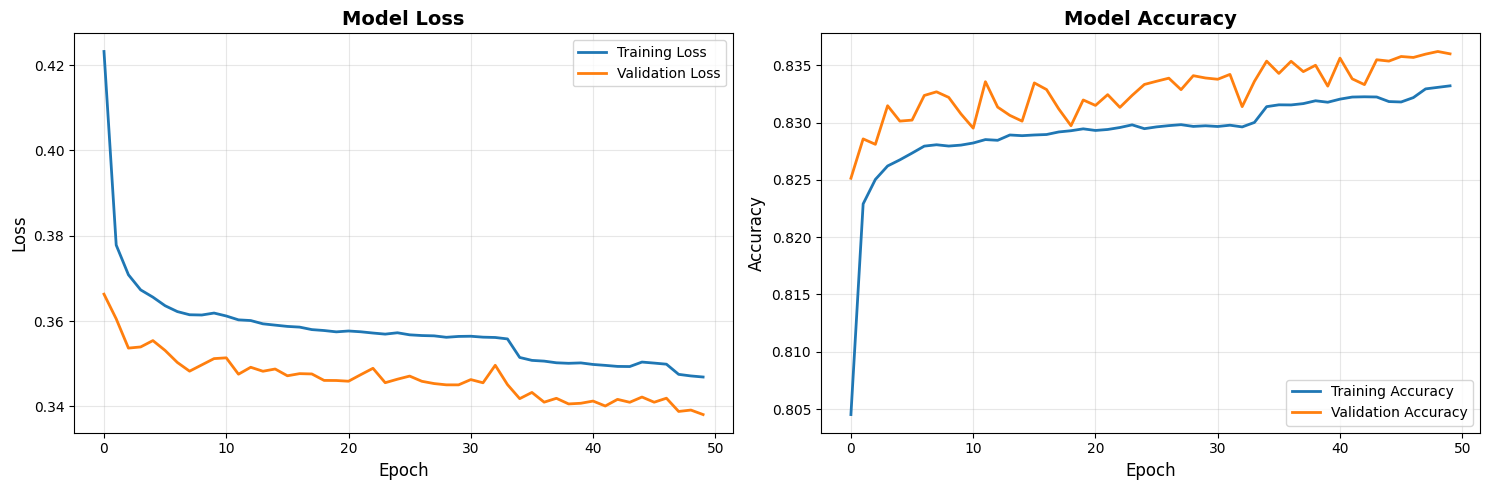

Confusion matrix plot saved: multiclass_confusion_matrix.png


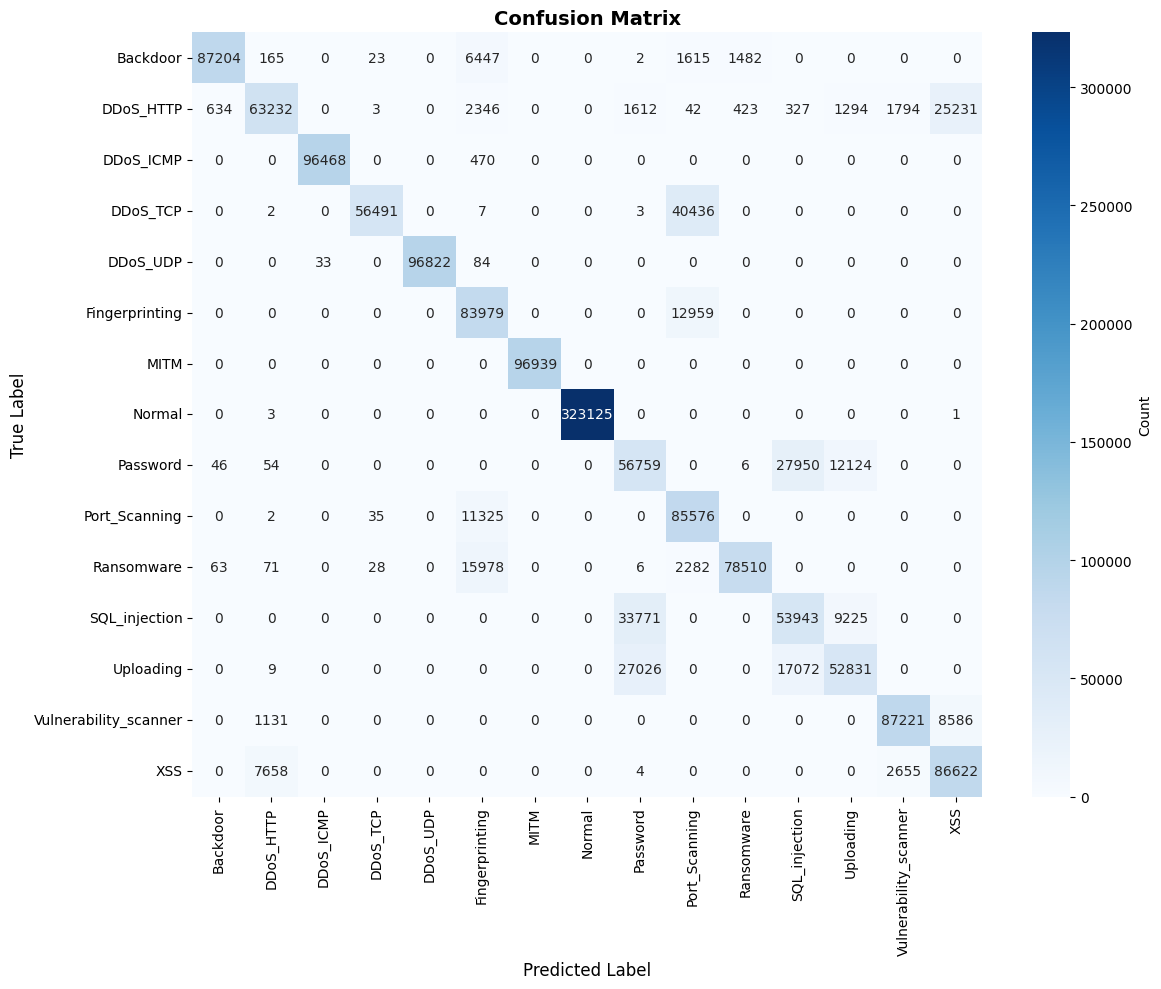

In [21]:
#Main Execution - Choose Binary or Multiclass
# Determine if binary or multiclass based on number of classes
if num_classes == 2:
    print("\n" + "="*70)
    print("BINARY CLASSIFICATION MODE")
    print("="*70)
    
    # Build binary model
    input_shape = (X_train_prep.shape[1], X_train_prep.shape[2])
    model = build_binary_cnn_lstm(input_shape)
    
    # Train
    model, history = compile_and_train_binary(
        model, X_train_prep, y_train_enc, X_val_prep, y_val_enc,
        epochs=50, batch_size=128
    )
    
    # Evaluate
    accuracy, precision, recall, f1, cm, y_pred = evaluate_model(
        model, X_test_prep, y_test_enc, label_encoder, is_binary=True
    )
    
    # Plot results
    plot_training_history(history, 'binary_training_history.png')
    plot_confusion_matrix(cm, ['Normal', 'Attack'], 'binary_confusion_matrix.png')
    
else:
    print("\n" + "="*70)
    print("MULTICLASS CLASSIFICATION MODE")
    print("="*70)
    
    # Build multiclass model
    input_shape = (X_train_prep.shape[1], X_train_prep.shape[2])
    model = build_multiclass_cnn_lstm(input_shape, num_classes)
    
    # Train
    model, history = compile_and_train_multiclass(
        model, X_train_prep, y_train_enc, X_val_prep, y_val_enc,
        epochs=50, batch_size=128
    )
    
    # Evaluate
    accuracy, precision, recall, f1, cm, y_pred = evaluate_model(
        model, X_test_prep, y_test_enc, label_encoder, is_binary=False
    )
    
    # Plot results
    plot_training_history(history, 'multiclass_training_history.png')
    plot_confusion_matrix(cm, label_encoder.classes_, 'multiclass_confusion_matrix.png')

In [22]:

# Cell 12: Save Model and Results
print("\n" + "="*70)
print("SAVING MODEL AND RESULTS")
print("="*70)

# Save the trained model
model.save('cnn_lstm_final_model.h5')
print("Model saved: cnn_lstm_final_model.h5")

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved: label_encoder.pkl")

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler saved: scaler.pkl")

# Save results
results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'num_classes': num_classes,
    'confusion_matrix': cm
}

with open('model_results.pkl', 'wb') as f:
    pickle.dump(results, f)
print("Results saved: model_results.pkl")

print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70)


SAVING MODEL AND RESULTS
Model saved: cnn_lstm_final_model.h5
Label encoder saved: label_encoder.pkl
Scaler saved: scaler.pkl
Results saved: model_results.pkl

TRAINING COMPLETE!
